In [1]:
import numpy as np
import matplotlib.pyplot as  plt
from matplotlib import cm
from tqdm import tqdm

from np_fun import prob, prob_part
#from tf_fun import init as tf_init
from Annealing import Annealer
from TrainingMaster import TrainingMaster

%load_ext autoreload
%autoreload 2

In [2]:
tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]

In [6]:
filenames = [
        './data_20_07_2018/data_20-07-2018_22-41_port0.csv',
        './data_20_07_2018/data_20-07-2018_22-41_port1.csv',        
        './data_20_07_2018/data_20-07-2018_22-44_port2.csv'
]
exp_params = {
    'scaling_channels':[0.99,1.0,1.0],
    'min_amp_per':[10,80-10,75],
    'start_end_index':[-160,-10],
}

In [4]:
filenames = [
    './data_11/data_20-11-2018_16-02_port0.csv',
    './data_11/data_20-11-2018_16-02_port1.csv',
    './data_11/data_20-11-2018_16-02_MPD_port2.csv'
]
exp_params = {
    'scaling_channels':[3,2,500],
    'min_amp_per':[0,10,300/4],
    'start_end_index':[-160,-10],
}

### Read scale shift and crop the data

In [9]:

def data_read(filenames):
    """
    Reads the data from filenames
    Returns
    --------------
    [(vals,times),(vals,times), ] : resulting unscaled data
    """
    raw_data = [np.genfromtxt(fname, delimiter=',') for fname in filenames]
    data = [ (filedata[:,0],filedata[:,1]) for filedata in raw_data ]
    #times = [np.array(i.T[1]) for i in exp_points]
    #exp_points = [np.array(i.T[0]) for i in exp_points]
    return data

def data_preprocess(data,params):
    """
    loads data, scales it and crops.
    Returns
    --------------
    (x_transformed,y_transformed)
    """
    def transformer(data, scaling, shifting):
        assert len(data)==len(scaling)==len(shifting), "transform params different dimensions"
        def transform(x, scale, shift):
            y = (x + shift)*scale
            return y
        return [transform(*i) for i in zip(data,scaling,shifting)]
    
    def clipper(data,clip_range):
        """
        Clips by range with respect to second (x) array of data
        """
        if clip_range:
            mask = np.array([clip_range[0]<dp<clip_range[1] for dp in data[1]])
            return (data[0][mask], data[1][mask])
        else:
            return data
        
    min_, ampl, per = params['min_amp_per']
    start_exp, end_exp = params['start_end_index']
    
    transformed = []
    for channel,scale in zip(data,params['scaling_channels']):
        scaling = (1/scale, 2*np.pi/per)
        shifting = ( -min_, -data[0][1][start_exp])
        ranging = (channel[1][start_exp], channel[1][end_exp]) 
        clipped = clipper(channel, ranging)
        scaled_shifted = transformer(clipped,scaling,shifting)
        transformed.append(scaled_shifted)
    return transformed


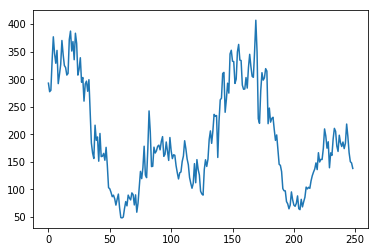

In [16]:

data = np.load('../data/new_experiment_2019/data_2019-11-15_15-55.npy', allow_pickle=True)
plt.plot(data[0][2][0][50:])

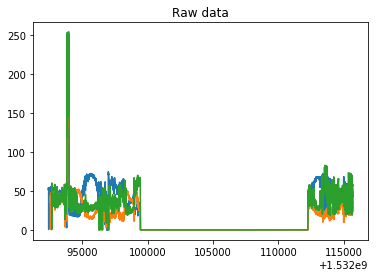

In [10]:
raw_data = data_read(filenames)

#%matplotlib notebook
plt.title('Raw data')
for channel in raw_data:
    plt.plot(channel[1],channel[0])
    

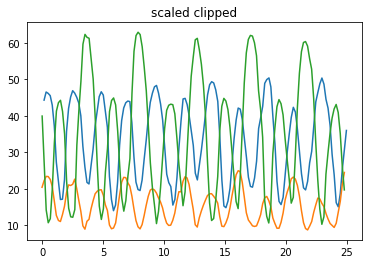

In [11]:
data = data_preprocess(raw_data,exp_params)

%matplotlib inline
plt.title('scaled clipped')
for channel in data:
    plt.plot(channel[1],channel[0])

In [8]:
def check_time_shift(data):
    shifts = [ max(data[0][1]-data[1][1]),
                max(data[1][1]-data[2][1]),
                max(data[0][1]-data[2][1]),
             ]
    print("Max delta of x-points in domain 0-1:", shifts[0])
    print("Max delta of x-points in domain 1-2:", shifts[1])
    print("Max delta of x-points in domain 0-2:", shifts[2])
    dx = data[0][1][1:]-data[0][1][:-1] 
    mean0 = np.mean(dx)
    print("x step on domain 0:", np.mean(dx),'variance of step:', np.std(dx))
    dx = data[1][1][1:]-data[1][1][:-1] 
    mean1 = np.mean(dx)
    print("x step on domain 1:", np.mean(dx),'variance of step:', np.std(dx))
    dx = data[2][1][1:]-data[2][1][:-1] 
    mean2 = np.mean(dx)
    print("x step on domain 2:", np.mean(dx),'variance of step:', np.std(dx))
    max_step = max([mean0,mean1,mean2])
    max_shift = max(np.abs(shifts))
    print("\nmax channel domain shift: %f\nmax domain step: %f"%(max_shift,max_step))
    if max_step*0.1 < max_shift:
        print("WARNING max shift is %f of domain step"%(max_shift/max_step))
        
check_time_shift(data)

Max delta of x-points in domain 0-1: -0.15810923738852622
Max delta of x-points in domain 1-2: -0.05199545725416854
Max delta of x-points in domain 0-2: -0.21944653777237377
x step on domain 0: 0.1675594932176304 variance of step: 0.0025555905998974598
x step on domain 1: 0.1675600932386206 variance of step: 0.0020527625975771623
x step on domain 2: 0.1675483589549824 variance of step: 0.00043568811003244837

max channel domain shift: 0.219447
max domain step: 0.167560
WARNING max shift is 1.309659 of domain step


**The measurment times seem to be shifted per channel.** Need to correct this by reindexing first channel



In [9]:
                
ch0 = data[0][0][1:], data[0][1][1:]
ch1 = data[1][0][:-1], data[1][1][:-1]
ch2 = data[2][0][:-1], data[2][1][:-1]
data_shifted = (ch0,ch1,ch2)
check_time_shift(data_shifted)

Max delta of x-points in domain 0-1: 0.009321729605549223
Max delta of x-points in domain 1-2: -0.05199545725416854
Max delta of x-points in domain 0-2: -0.051987068296732275
x step on domain 0: 0.16756071525125474 variance of step: 0.002564225255739701
x step on domain 1: 0.16756928655369782 variance of step: 0.00205669426486122
x step on domain 2: 0.16754020442696743 variance of step: 0.00042576283705000103

max channel domain shift: 0.051995
max domain step: 0.167569
WARNING max shift is 0.310292 of domain step


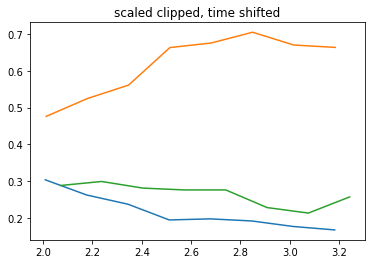

In [10]:
plt.title('scaled clipped, time shifted')
for channel in data_shifted:
    plt.plot(channel[1][10:18],channel[0][10:18])

If domains are not equal, which should be used for function evaluation? 

The ideal variant is evaluating each channel at it's own domain but we have 3-d output fucntion.

Therefore, first channlel domain will be used. The biggest error will be at the 2nd channel, of order 0.3 dy/dx

In [11]:
error_rate = 0.31*np.max(np.abs(data[2][0][:-1]-data[2][0][1:]))
print("error abs value",error_rate)
print("error relative to max %.3f%%"%(error_rate/max(data[2][0])))


error abs value 0.054869999999999995
error relative to max 0.071%


[[0.14658432 0.03020222 0.03592419]
 [0.04306497 0.13250839 0.03254601]]
[[ 0.09810427-0.3700809j   0.06722978+0.16025723j -0.06239675+0.1789716j ]
 [ 0.11702747-0.17137544j -0.01614874+0.36365865j  0.06770602+0.16721815j]]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f27c859df28>,
      dtype=object)

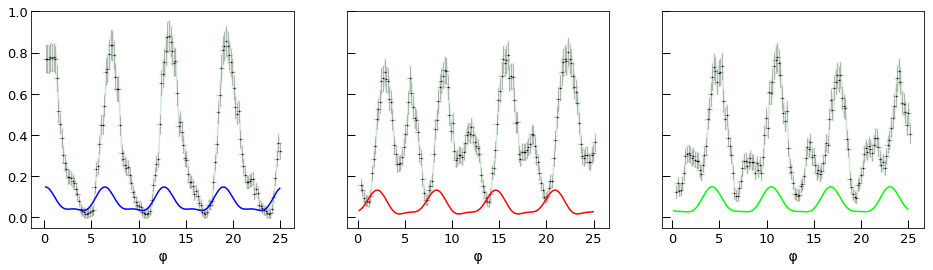

In [33]:

def func(x):
    return np.abs(np.square(prob_part(0,0,0,0,phi=x)))
print(func(np.array([0,21])))
print(prob_part(0,0,0,0,phi=np.array([0,21])))

def set_fonts_ticks(fig,ax):
    fontsize =14
    try:
        ax.set_xlabel(' φ ',fontsize=fontsize)
        #ax.set(ylabel=' Intensity ')
    except:
        plt.ylabel(' Intensity ', fontsize=fontsize)
        plt.xlabel(' φ ',fontsize=fontsize)
    
    tick_width =1
    ax.tick_params(axis="y",direction="in",labelsize=13,width=tick_width,length=8)
    ax.tick_params(axis="x",direction="in",labelsize=13,width=tick_width, length=8)
    
def plot3(func, data, on_same=False):
    domain_used = data[0][1]
    domain, func_vals = sampl(func,domain_used[0],domain_used[-1],200)
    func_vals = np.array(func_vals).T
    %matplotlib inline
    figsize=(16,4)
    if on_same:
        plt.figure(figsize=figsize)
        ax =[plt,plt,plt]
        f = plt
    else:
        f,ax = plt.subplots(1,3,figsize=figsize,sharey=True)
    colors  = ['blue','red','green']
    colors  = [cm.brg(i) for i in np.linspace(0,1,3)]
    for i,color,channel in zip(range(3),colors,data):
        #ax[i].errorbar(pts,data[i],xerr=4*np.pi/100,yerr=0.03+0.02*data[i],fmt='none',color='gray',capsize=2)
        y, x = channel
        errx = 0.02+0.06*y
        ax[i].fill_between(x,y+errx,y-errx,color='green',alpha=0.1,label='error region')
        #ax[i].fill_between(pts,data[i]+errx_[i],data[i]-errx_[i],color='green',alpha=0.1)
        ax[i].errorbar(x, y, xerr=4*np.pi/50, yerr=errx,capthick=0.2,elinewidth=0.5,fmt='none',color='gray',capsize=1.5)
        set_fonts_ticks(f,ax[i])
        ax[i].plot(x, y,'.',markersize=1,color='black',label=r'data $|%i\rangle$'%i)
        ax[i].plot(domain,func_vals[i],label=r'function $|%i\rangle$'%i,color=color)
    #ax[0].legend(loc=1)
    return ax
    #plt.legend()

plot3(func,data, on_same=False)

In [13]:
data_orig = data
transform_fun = lambda x: 1*np.sqrt(np.square(x)*(1+0.5*np.power(x,6)))


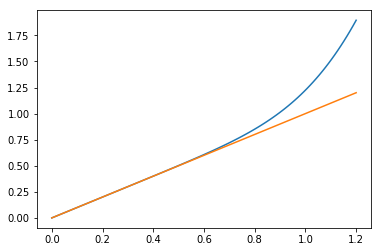

In [14]:
x = np.linspace(0,1.2,100)
y = transform_fun(x)
plt.plot(x,y)
plt.plot(x,x)

In [25]:
fixed = [0,0]
#tst = lambda z,x: np.sin(z[0]*x+z[1])+z[0]+np.cos(2*z[1])+z[0]*z[1]
carr =lambda f,z: lambda x: f(z,x)
#sampl_map_depr = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),list(map(f,np.linspace(fm,to,cnt)))]
sampl = lambda f,fm=0,to=10,cnt=100: [np.linspace(fm,to,cnt),f(np.linspace(fm,to,cnt))]
np_map = lambda f,x: np.array(list(map(f, x)))

device = lambda z,x:np.abs(np.square(prob_part(z[0],z[1],fixed[0],fixed[1],phi=x)))
cost = lambda f,data, domain: np.sum(np.square(f( domain).T-data))

one_channel = lambda z,x: device(z,x).dot(np.array([0,1,0]).T)


domain = np.array(data_shifted[0][1])
points = np.array([ x[0] for x in data_shifted ])

cost(carr(device,[0,0]),points,domain)


58.758620667261354

In [26]:
def get_parametric(func,dots=20):
    xrange = np.linspace(-7.0, 7.0, dots)
    yrange = np.linspace(-7.0, 7.0, dots)
    p = np.zeros((len(xrange),len(yrange)))
    f2d = lambda x,y:cost(carr(func,[x,y]),points,domain)
    #f2d = lambda x,y:opt.prob(x,y,12)
    for x in tqdm(range(len(xrange))):
        for y in range(len(yrange)):
            p[y,x] =  f2d(xrange[x],yrange[y])
    return xrange,yrange,p

def display_parametric(p):
    best_pos=np.unravel_index( np.argmin(p),p.shape)
    best_pos = [xrange[best_pos[0]], yrange[best_pos[1]]]
    print("Min cost is:",np.min(p),' at position ',best_pos)
    
    %matplotlib notebook
    plt.contourf(xrange,yrange,p,100)
    #plt.savefig('fig.png',dpi=300)
xrange,yrange,p = get_parametric(device)
print()

100%|██████████| 20/20 [00:00<00:00, 40.54it/s]

In [27]:
best_pos=np.unravel_index( np.argmin(p),p.shape)
best_pos = [xrange[best_pos[1]], yrange[best_pos[0]]]
print("Min cost is:",np.min(p),' at position ',best_pos)

Min cost is: 56.982116219925615  at position  [-1.1052631578947372, -7.0]


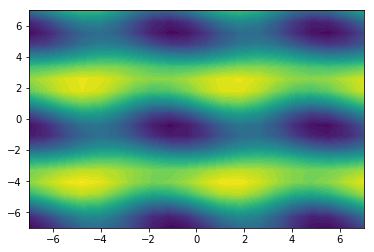

In [28]:

%matplotlib inline
plt.contourf(xrange,yrange,p,50)

#plt.scatter(*np.array(opt.dots).T,c=np.arange(len(opt.dots)),marker='o',alpha=0.7)
#plt.savefig('fig.png',dpi=300)

In [29]:

point = [-0.5,2.52]
point = best_pos
fun = carr(device,point)
print('cost is ',cost(fun,points,domain))
plot3(fun,data)
#plt.figure(figsize=(15,5))
#plt.plot(pts,data[1],'D')
#plt.plot(*sampl(carr(unit,point),0,14))

cost is  56.982116219925615


NameError: name 'plot3' is not defined

In [30]:
kek = carr(device,[0,0])
carr_dev = lambda x,y:carr(device,[x,y])
print("cost",cost(carr_dev(0,0),points,domain))
plot3(kek,data)

plt.savefig('./figs/unfitted_cost19.5.eps')

cost 58.758620667261354


NameError: name 'plot3' is not defined

### Optimisation


In [21]:
unit_all = lambda z,x: np.dot([0,1,0],np.abs(np.square(prob_part(z[0],z[1],z[2],z[3]+z[8]*x, phi=z[4]*x+z[5]))).T)*z[6]+z[7]
unit_all_sh = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3]+z[8]*x, phi=z[4]*x+z[5]))).T*z[6]+z[7]
unit_all = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T*z[6]+z[7]
def unit_all_ext(z,x):
    scale = np.array([z[6],z[8],z[10]]).reshape(-1,1)
    bias= np.array([z[7],z[9],z[11]]).reshape(-1,1)
    sq = np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T
    return np.multiply(sq,scale)+bias
    


In [22]:


opt = Annealer(unit_all_ext,points_data=(domain,points),energy=0.01)
#opt = Annealer(unit_all_sh,points_data=(pts,data),energy=3)
start = [ 1.97826339, 0.61469571, -2.23318571, -2.48897276,-1.56313198,-0.26907035,1.55959301, 0.06752256]
start_1d = [ -4.47259827, -16.59763161,  -0.10024442,  -4.70741011, -1.5601084, 8.85820219,   1.26772687,  -0.01726806]


In [24]:
start = [0,0,0,0,1,0]
#start = [0,0,0,0,-1,0,1,0]
#start = [1.97641972,  0.46830365, -2.34256105, -2.7767623,  1.53977032, -0.45830121]
#start+= [1.5291502, -0.04907852]*3
start+= [1., 0]*3
#start = [1.97641972,  0.46830365, -2.34256105, -2.7767623,  -1.53977032, -0.45830121, 1.48391502, -0.04907852]
#start = [-25.648831,   -16.91017209, -10.20137638 , 11.01714674, 1.12643974, -6.81656814,3.31360078,-0.39924749]
#----
#start = [ 1.97826339, 0.61469571, -2.23318571, -2.48897276,-1.56313198,-0.26907035,1.55959301, 0.06752256]
#start = [ 1.967253,0.48585659,-2.33491508,-2.78094184,-1.54426616,-0.48716136, 1.48614562,-0.04299893]
#start = [ 1.96138566 ,0.50875255,-2.35032956,-2.76200031,-1.54908902,-0.49052423,1.48531792,-0.03484366]
#start = [ 1.9275381  ,0.59061329,-2.34954988,-2.7051162,-1.55274685,-0.45482005,1.48985282,-0.01583345]
#start = [ 1.92458872e+00 ,6.32120251e-01,-2.37815466e+00,-2.69702060e+00,-1.55968124e+00,-4.25383658e-01, 1.49321705e+00,5.56355378e-04]
#start = [ 1.92847165, 0.6375538, -2.36868504,-2.68888271,-1.55939054,-0.42065203]#,1.49548067, 0.00481282]
#-----
#start = [ 2.12656275, 0.47688792,-1.98577565,-2.35514891,-1.55995708,-0.23963736,1.44947365,-0.01452177]
#-----
#start = [1.95919984e+00, 8.19740538e-01,-2.26230497e+00,-2.72042327e+00,-1.55939054e+00,-4.20652030e-01 ,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start = [1.95919984e+00, 8.19740538e-01,-2.26230497e+00,-2.72042327e+00,-1.55939054e+00,2.5,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start = [0,0,0,0,-1.55939054e+00,2.5,1.53312784e+00 ,1.68078388e-03,1.44252585e+00 ,9.75280255e-02 ,1.48103378e+00,-2.73642836e-02]
#start+= [1.5291502, -0.04907852]*3
#----
#start = [-2.32541952,-0.9608898, -0.13852067,-5.15517973, 0.97465464, 1.31748816, 1.53951879, 0.01011564, 1.02387153 ,-0.06185487,1.36900721,-0.03954456]
#start = [-3.36118403, 0.96926396, 0.10836383,-3.89032361, 0.97549022, 1.93320694,1.6801596, -0.01879222, 1.49163158, 0.07257146, 1.5428213, -0.11929513]
#start = [-3.49121636, 0.87385935,-0.08959715,-3.91629894,0.9750151,1.9603849,1.49616193, 0.0190554,1.36912646,0.10818433,1.36644564,-0.05666999]
#----
#start = [-0.35676228,-0.03535678,-0.43482671,-0.34998957,-0.97160596, 2.38082973,1.12625908, 0.1297592,1.17688177,  0.15757579,  0.99144728,  0.06590635]
#start = [-0.33552876,-0.03830224,-0.18863695,-0.33352386,-0.97145185, 2.39195415,1.22306303, 0.1326142,1.11796584, 0.1699339,  0.98328385,-0.0180364 ] 
#start = [-0.24526258, 0.15732052,-0.19880247,-0.28151031,0.97291334, 2.46447037,1.08338516, 0.11748036, 1.0809959,  0.14362178, 1.18665954, 0.04184873]
#-----
#start = [-0.57306714, 0.63175266,-0.36122907,-0.3208004 ,-0.97451166, 2.54132486,1.181723,0.07407222 ,1.27971451 ,0.10763267,1.22769368 ,0.02456477] 
#-----
#start = [0.07661972,-0.07106976,-0.05549605,-0.11803781, 0.97650235,1.72300005, 1.21218324 ,0.01452341 ,0.97419767 ,0.16275044, 1.10270804 ,0.11445055]
#start = [-0.31160797, 0.10608301,0.05620119,-0.42756725 ,0.9737802,1.86668951,1.24243826, 0.01624791, 1.03994315, 0.15482945, 1.12628097, 0.13422101]
#start = [-0.51848071, 0.44655803,-0.10513339,-0.66608409, 0.9748721,1.80340634,1.27070089,-0.00278106, 1.22260681, 0.09637843, 1.20320884, 0.10860261]
#start = [-0.3203845,0.16993224,-0.32911475, 0.01809247, 0.97449245,-1.2447041,1.10730278, 0.10217422, 1.04108196, 0.17192258, 1.20898653, 0.0315673 ]

#------ MPD,newdata
#start = [-0.19547043,-0.15920402, -0.03079716, 0.33504199, -1.03744451 , 0.15439241, 0.03802504,-0.13923389, 0.01140135,-0.13494652, 0.03209776,-0.12951291]
#start = [-0.21502694,-0.16672425,-0.0313105,  0.3356425 ,-1.03074859, 0.06572623,  0.03849316,-0.13929281, 0.01329539,-0.13524289, 0.03283929,-0.12990624]
#start = [-0.27687533,-0.20099186,-0.05894471, 0.33400533,-1.00468929,-0.3520762, 0.04219883,-0.13994591, 0.01520531,-0.13590523,0.03625139,-0.13081575] 

#------ MPD,newdata, new scaling of channles
start = [-0.77338807, 0.71445302,-0.75957359, 0.13603367,0.98436724,-0.10741559,1.17953092,-0.00559215, 0.96529957, 0.13260642, 0.64658049, 0.19579248]

start = opt.best
#start[8]*=1.1
#start[9]-=0.1

#start[4]=-start[4]
#start[5]-=5.4

#start[0]*=0.9
#start[1]*=0.9
#start[2]*=0.9
#start[3]*=0.95

#start[:4]=[-1.36891766, -0.06588248, -0.20562201, -0.22415281]
##start = point
#start_1d = [ -4.47259827, -16.59763161,  -0.10024442,  -4.70741011 , -1.5601084, 8.85820219,   1.26772687,  -0.01726806]
#start = [ 1.65353401, -0.47372438, -3.24028015, -2.16909992, -1.57036921,  0.08920259, 1.69030152, -0.148071]
scales= np.array([0.5]*4+[0.9,0.9]+[.9,.9]*3)*0.000005

#scales= np.array([0,0,0,0,0,0]+[0.2,0.3]*3)*0.05
point,cost = opt.opt(start_point=start,
                     energy=0.00001,
                     scales =scales,
                     max_steps =5000
                    )

print(point,cost)
print(opt.best)

AttributeError: 'Annealer' object has no attribute 'best'

1.661496419234685


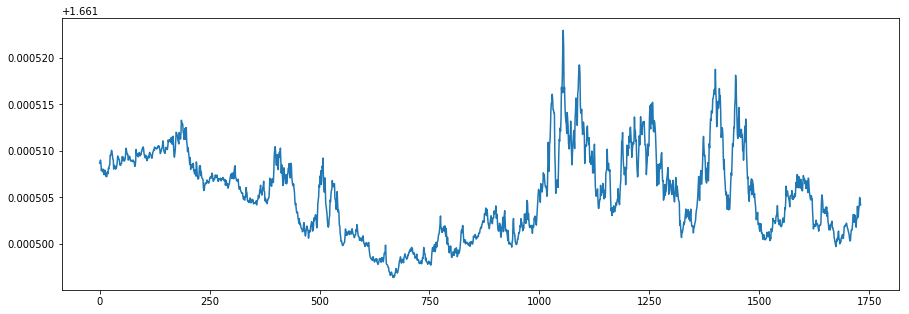

In [328]:
plt.figure(figsize=(15,5))
plt.plot(opt.costs)
print(np.min(opt.costs))

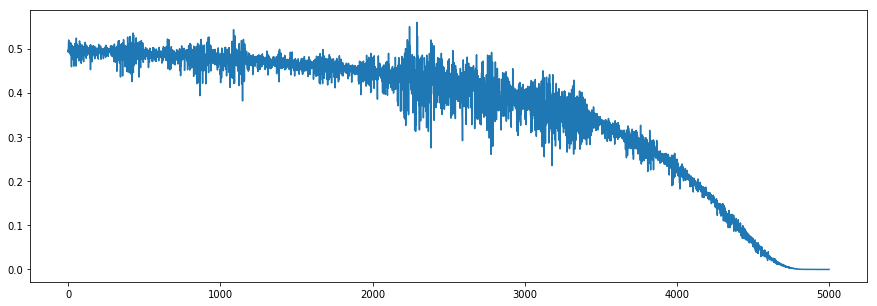

In [329]:

plt.figure(figsize=(15,5))
plt.plot(opt.probs)

best cost: 1.6614961105433543


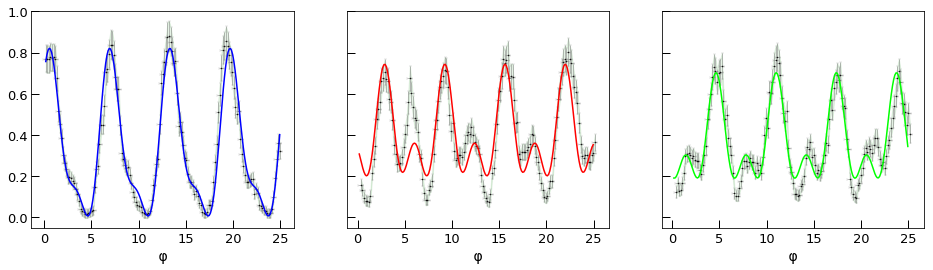

In [330]:
%matplotlib inline
#opt.best+=np.array([0]*8+[0.05,-0.05,0,0])
s = list(opt.best)
best_fun= carr(opt.func,s)
fourier_fun= carr(opt.func,[0,0,0,0]+list(opt.best[4:]))
print('best cost:',opt.cost(best_fun,))
#plot3(lambda x: best_fun(x).T,on_same=True)
axes = plot3(lambda x: best_fun(x).T,data)
#lin,d = sampl(fourier_fun,pts[0],pts[-1],200)
#for i in range(3):
    #axes[i].plot(lin,d[i],'--')
plt.savefig('figs/fitted_cost1-37_bars.pdf')


In [310]:
%matplotlib inline
%matplotlib inline
unit_all_1 = lambda z,x: np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+z[5]))).T*z[6]+z[7]
print(opt.best)
def unit_ideal(z,x):
    scale = np.array([z[6],z[8],z[10]]).reshape(-1,1)
    bias= np.array([z[7],z[9],z[11]]).reshape(-1,1)
    sq = np.abs(np.square(prob_part(z[0],z[1],z[2],z[3], phi=z[4]*x+2.5))).T
    return np.multiply(sq,scale)+bias
 
best_fun= carr(unit_ideal,[0,0,0,0]+opt.best[4:])
print(opt.cost(best_fun))
plot3(lambda x: best_fun(x).T,points_data=(opt.points,data))

[-0.75174489  0.75537347 -0.74777574  0.31618386  0.98471389 -0.18465898
  1.17904518 -0.00441767  0.90797581  0.15222282  0.64685447  0.19216374]


ValueError: operands could not be broadcast together with shapes (4,) (8,) 

In [311]:
#lin,d = sampl(func,0,12.56,100)
#d = np.array(d).T
print(min(pts),max(pts[:-20]))
f = best_fun(pts)
%matplotlib inline
fs=(16,4)
print(np.sum(np.square(data - f)))
fig,ax = plt.subplots(1,3,figsize=fs,sharey=True)
for i in range(3):
    ax[i].plot(pts, data[i]-f[i],'D',label='data%i'%i)
plt.legend()
best_point = opt.best

NameError: name 'pts' is not defined

In [160]:
print(best_point)


[-0.31305734  0.1920463  -0.28419054 -0.61196897 -0.97602927  2.28265513
  1.0727569   0.14157131  1.2634214   0.02928405  1.05893013  0.04638161]
